In [24]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import seaborn as sns
import json
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
with open('web/data/incomeTax.json') as data_file:    
    data = json.load(data_file)

# Testing
print data[0]["data"]["New Brunswick"][0]["rate"]
print data[0]["data"]["New Brunswick"][0]["upper"]

9.68
39305


In [26]:
def getAvgRate(location, income, data):
    
    def govtAvg(govt):
        # Fetch the tax bracket data
        brackets = data[govt]
        untaxed_income = income # This will keep track of the part of the income that has not been taxed yet
        tax_paid = 0.0 # A running total of the amount of tax paid
        lower = 0 # The lower value of tax bracket
        n = 0 # Keeps track of which tax bracket we're in
        while untaxed_income > 0:
            # Fetch the current bracket
            bracket = brackets[n]
            # This checks to see if we're on the final bracket
            try:
                upper = int(bracket["upper"]) # Upper value of tax bracket
                rate = float(bracket["rate"])/100.0 # Tax rate of bracket
            except:
                upper = "max" # There is no upper value for the final bracket
                rate = float(bracket["rate"])/100.0

            if upper == "max" or income < upper:
                # Does the calculation for the final bracket the person falls into
                tax_paid = tax_paid + untaxed_income*rate
                untaxed_income = 0
            else:
                # Gets the tax paid on the brackets a person is totally above
                tax_paid = tax_paid + (upper - lower)*rate
                untaxed_income = untaxed_income - (upper - lower)
                lower = upper
                n = n + 1
        # This is the average rate the person ends up paying
        return round(tax_paid / income * 100.0, 2)
    
    avg_fed_tax = govtAvg("Federal")
    avg_prov_tax = govtAvg(location)
    
    avg_tax_total = round(avg_prov_tax + avg_fed_tax, 2)

    return {str(income) : {"avg_fed": avg_fed_tax, "avg_prov": avg_prov_tax, "avg_total": avg_tax_total}}

In [27]:
# Gets the average tax paid for a number of incomes for a given province in a given year
def provAvgs(province, year_data):
    incomeList = xrange(5000, 500000, 5000)
    return [getAvgRate(province, income, year_data) for income in incomeList]

In [28]:
def processYear(year_data):
    yearData = {}
    for province, brackets in year_data.iteritems():
        yearData[province] = provAvgs(province, year_data)
    return yearData

In [29]:
allData = {}
for year_record in data:
    year = year_record["year"]
    year_data = year_record["data"]
    allData[year] = processYear(year_data)

In [30]:
# Convert the results into an object that can be visualized
# with each province representing a line, the income as the x-value
# and the avg tage as the y-value
year_prov_avgs = allData["2014"]
year_dict = {}
for prov, income_data in year_prov_avgs.iteritems():
    prov_dict = {}
    for income_record in income_data:
        income = income_record.keys()[0]
        avg_tax = income_record.values()[0]['avg_total']
        prov_dict[int(income)] = avg_tax
    prov_series = Series(prov_dict)
    year_dict[prov] = prov_series
year_df = pd.concat(year_dict, axis=1)
year_df = year_df.drop('Federal', axis=1)

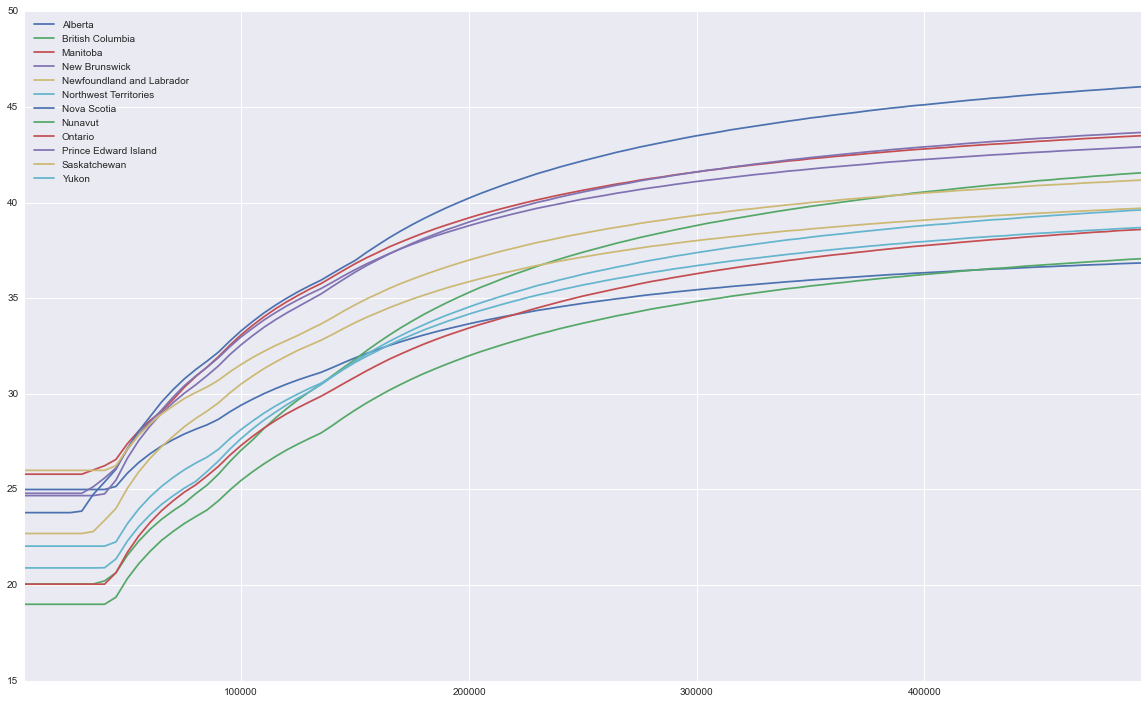

In [31]:
year_df.plot(figsize=(20, 12))

In [49]:
d3_data = []
for province, avgs in year_dict.iteritems():
    line_data = {"values":[], "key": ""}
    line_data["key"] = province
    for income, avg in avgs.iteritems():
        line_data["values"].append({"x": income, "y": round(avg,2)})
    d3_data.append(line_data)
with open('web/data/avgTax.json', 'w') as data_file:    
    json.dump(d3_data, data_file)

In [33]:
year_dict

{u'Alberta': 5000      25.00
 10000     25.00
 15000     25.00
 20000     25.00
 25000     25.00
 30000     25.00
 35000     25.00
 40000     25.00
 45000     25.16
 50000     25.85
 55000     26.41
 60000     26.87
 65000     27.27
 70000     27.60
 75000     27.90
 80000     28.15
 85000     28.38
 90000     28.67
 95000     29.06
 100000    29.41
 105000    29.72
 110000    30.01
 115000    30.27
 120000    30.51
 125000    30.73
 130000    30.93
 135000    31.12
 140000    31.37
 145000    31.63
 150000    31.88
           ...  
 350000    35.95
 355000    35.99
 360000    36.03
 365000    36.07
 370000    36.11
 375000    36.15
 380000    36.19
 385000    36.23
 390000    36.26
 395000    36.30
 400000    36.33
 405000    36.36
 410000    36.39
 415000    36.43
 420000    36.46
 425000    36.49
 430000    36.52
 435000    36.54
 440000    36.57
 445000    36.60
 450000    36.63
 455000    36.65
 460000    36.68
 465000    36.70
 470000    36.73
 475000    36.75
 480000    36.77
 4